# 知识图谱

## 知识图谱基础概念
[查看地址](https://rarelimiting.feishu.cn/wiki/VyR7wrYLTiitrzkjIDAcV7F0nYc)

内容较多，按需学习

![](https://miro.medium.com/max/3868/1*64AZ80NoAO8wH1RVGToSKg.png)<a id="TOC0"></a> <br>
1. [**介绍**](#KG1)

    1.1 [**什么是知识图谱？**](#KG11)
    
    1.2 [**知识图谱中的数据表示？**](#KG12)
    
    1.3 [**导入依赖项**](#KG13)
    
    1.4 [**句子分割**](#KG14)
    
    1.5 [**实体提取**](#KG15)
    
    1.6 [**关系提取**](#KG16)
    
    1.7 [**构建知识图谱**](#KG17)
     
1. [结论](#KG2) 


## 1. 介绍 <a id="KG1"></a> <br>
### 1.1 什么是知识图谱？ <a id="KG11"></a> <br>

知识图谱是一种存储从信息提取任务中得到的数据的方式。许多知识图谱的基本实现都利用了我们称之为三元组的概念，即一组三个项目（主语、谓语和宾语），我们可以用它来存储关于某事物的信息。

**我们可以将图定义为一组节点和边。**
![](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/10/graph_link.png)
这里的节点A和节点B是两个不同的实体。这些节点通过表示两个节点之间关系的边相连。现在，这是我们可以构建的最小知识图 - 也被称为**三元组**。知识图谱有各种形状和大小。

### 1.2 知识图谱中的数据表示？ <a id="KG12"></a> <br>
让我们以这个句子为例：

**伦敦是英格兰的首都。威斯敏斯特位于伦敦。**

经过一些基本处理，我们会得到两个三元组，如下所示：

**(伦敦, 是首都, 英格兰), (威斯敏斯特, 位于, 伦敦)**

因此，在这个例子中，我们有三个唯一实体（伦敦、英格兰和威斯敏斯特）和两个关系（是首都、位于）。要构建一个知识图谱，我们在图中只有两个关联节点与实体，以及与关系相关的顶点，我们将得到类似于这样的图：
![](https://programmerbackpack.com/content/images/2020/01/Screenshot-2020-01-26-at-17.48.39.png)
手动构建知识图谱是不可扩展的。没有人会浏览成千上万份文件并提取所有实体及其之间的关系！

这就是为什么机器更适合执行此任务，因为即使浏览数百或数千份文件对它们来说也是小菜一碟。但是另一个挑战是 - 机器不理解自然语言。这就是自然语言处理（NLP）出现的原因。

要从文本构建知识图谱，重要的是让我们的机器理解自然语言。这可以通过使用NLP技术，如句子分割、依存解析、词性标注和实体识别来实现。

### 1.3 导入依赖项和加载数据集 <a id="KG13"></a> <br>

In [52]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [53]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("../input/wiki-sentences1/wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [54]:
candidate_sentences['sentence'].sample(5)

2995                               likewise, tri-acetate stock is also vulnerable to deterioration.  
3557                   el angel  is a 2018 argentine-spanish true crime film directed by luis ortega.
2450                           many successful tamil films have been remade by other film industries.
1449                                  other hindi stars include anil kapoor, madhuri dixit and kajol.
1684    parallel cinema films, in and outside bollywood, tended to be less popular at the box office.
Name: sentence, dtype: object

### 1.4 句子分割 <a id="KG14"></a> <br>
构建知识图谱的第一步是将文本文档或文章分割成句子。然后，我们将仅列出那些句子，其中恰好有1个主语和1个宾语。

In [55]:

doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... amod
d823 ... pobj


### 1.5 实体提取 <a id="KG15"></a> <br>
从句子中提取单词实体并不是一项困难的任务。我们可以借助词性标注（POS）标签轻松完成这项任务。名词和专有名词将成为我们的实体。

然而，当实体跨越多个单词时，仅凭词性标注是不够的。我们需要解析句子的依赖树。

要构建知识图谱，最重要的是节点和它们之间的边。

这些节点将是存在于维基百科句子中的实体。边是连接这些实体之间的关系。我们将以无监督的方式提取这些元素，即，我们将使用句子的语法。

主要思想是遍历句子，并在遇到主语和宾语时提取它们。然而，存在一些挑战 — 实体可能跨越多个单词，例如，“红酒”，而依赖解析器仅将单个单词标记为主语或宾语。

因此，我创建了下面的函数，用于从句子中提取主语和宾语（实体），同时克服上述提到的挑战。为了方便起见，我将代码分成多个部分：

In [56]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

**块 1**

在这个块中定义了一些空变量。prv_tok_dep和prv_tok_text将保存句子中前一个单词的依赖标签和前一个单词本身。prefix和modifier将保存与主语或宾语相关联的文本。

**块 2**

接下来，我们将循环遍历句子中的标记。我们将首先检查标记是否为标点符号。如果是，则我们将忽略它并继续下一个标记。如果标记是复合词（依赖标签为“compound”），我们将将其保留在前缀变量中。复合词是多个单词组合在一起形成具有新含义的单词（例如 - “足球场”, “动物爱好者”）。

每当我们遇到主语或宾语时，我们将将此前缀添加到其中。我们将对修饰词进行相同的操作，例如“漂亮的衬衫”, “大房子”等。

**块 3**

在这里，如果标记是主语，则将其作为ent1变量中的第一个实体捕获。前缀、修饰词、prv_tok_dep和prv_tok_text等变量将被重置。

**块 4**

在这里，如果标记是宾语，则将其作为ent2变量中的第二个实体捕获。前缀、修饰词、prv_tok_dep和prv_tok_text等变量将再次被重置。

**块 5**

一旦我们在句子中捕获了主语和宾语，我们将更新前一个标记及其依赖标签。

让我们在一个句子上测试这个函数：

In [57]:
get_entities("the film had 200 patents")

['film', '200  patents']

很好，看起来按计划运行正常。在上面的句子中，“film”是主语，“200专利”是宾语。

现在我们可以使用这个函数来提取我们数据中所有句子的实体对：

In [58]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:46<00:00, 92.09it/s]


列表entity_pairs包含来自维基百科句子的所有主语-宾语对。让我们看一些例子：

In [59]:
entity_pairs[10:20]

[['we', 'tests'],
 ['m global', 'international sales rights'],
 ['canadian musician robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['', 'telepath selene gallio'],
 ['singer', 'sequel']]

正如您所看到的，这些实体对中有一些代词，如“我们”、“它”、“她”等。我们希望使用专有名词或名词代替。也许我们可以进一步改进get_entities()函数以过滤掉代词。

### 1.6 关系提取 <a id="KG16"></a> <br>
实体提取只完成了一半的工作。要构建知识图谱，我们需要边来连接节点（实体）之间。这些边是节点对之间的关系。

我们的假设是谓语实际上是句子中的主要动词。

例如，在句子中 - “1929年有六十部好莱坞音乐剧上映”，动词是“上映”，这将是我们从该句子生成的三元组中使用的谓语。

下面的函数能够从句子中捕获这样的谓语。在这里，我使用了spaCy的基于规则的匹配：

In [60]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

函数中定义的模式尝试找到句子中的ROOT词或主要动词。一旦确定了ROOT，模式会检查它是否后跟介词（'prep'）或代理词。如果是，则将其添加到ROOT词中。
让我给您展示一下这个函数的简要内容：

In [61]:
get_relation("John completed the task")

'completed'

In [62]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:45<00:00, 95.95it/s] 


让我们看一下我们刚刚提取的最常见的关系或谓词：

In [63]:
pd.Series(relations).value_counts()[:50]

is               372
was              302
released on       88
are               74
include           72
were              67
released          42
's                39
composed by       35
became            31
have              31
has               30
become            28
released in       27
included          25
called            21
had               21
made              20
considered        20
been              19
produced          19
used              18
scheduled         17
be                16
received          15
written by        15
stars             14
hired             14
wrote             14
produced by       14
introduced in     13
went              13
wanted            12
directed by       12
began             11
won               11
began in          11
set               10
sold              10
features          10
gave              10
cast as            9
used in            9
reported           9
produced in        9
shot in            9
includes           9
said         

### 1.7 构建知识图谱 <a id="KG17"></a> <br>

最终，我们将从提取的实体（主语-宾语对）和谓词（实体之间的关系）创建一个知识图谱。

让我们创建一个包含实体和谓词的数据框：

In [64]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

接下来，我们将使用networkx库从这个数据框创建一个网络。节点将表示实体，节点之间的边或连接将表示节点之间的关系。

这将是一个有向图。换句话说，任何连接的节点对之间的关系不是双向的，而是从一个节点到另一个节点。

In [65]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

让我们绘制这个网络：

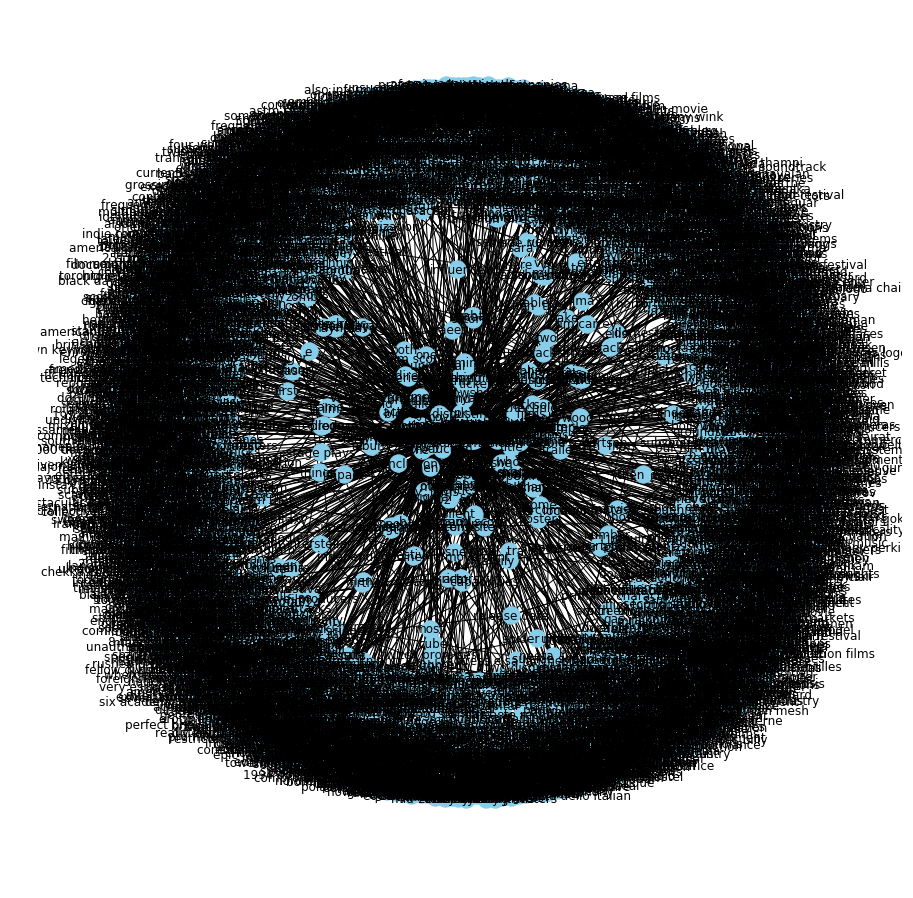

In [66]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

嗯，这并不完全符合我们的期望（尽管看起来还是相当壮观的！）。

事实证明，我们创建了一个包含所有我们拥有的关系的图。要可视化具有这么多关系或谓词的图形确实很困难。

因此，建议只使用一些重要的关系来可视化图形。我将逐个关系进行展示。让我们从关系“composed by”开始：

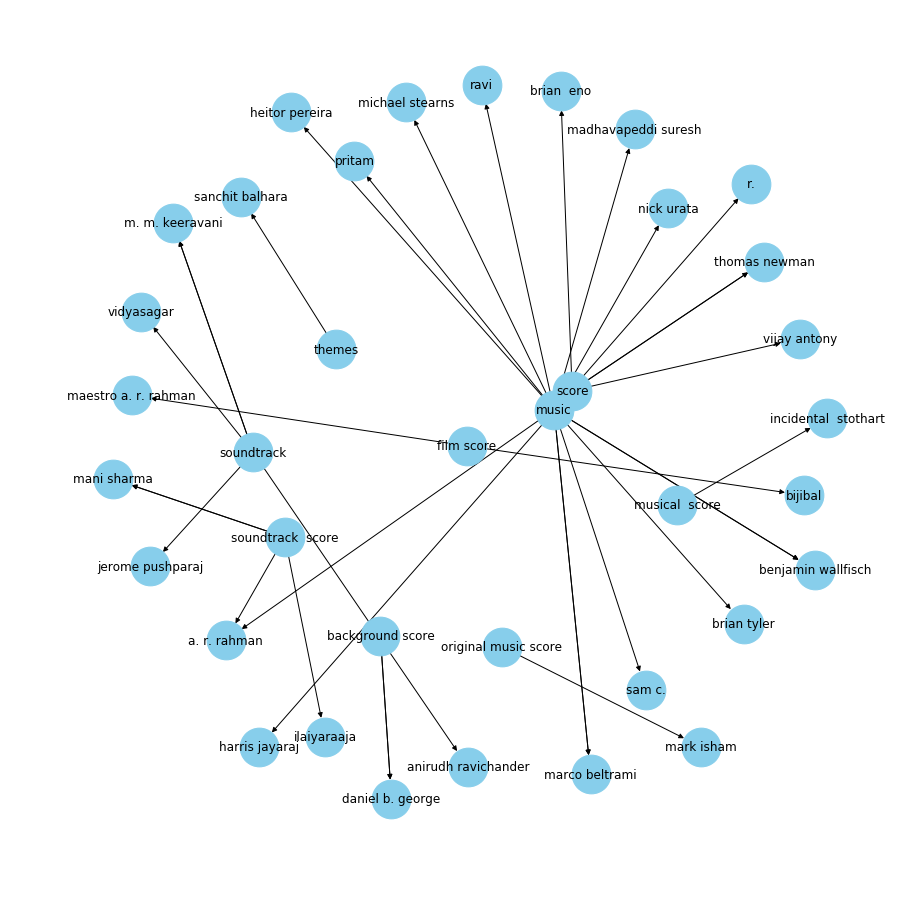

In [67]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

这是一个更清晰的图。这里的箭头指向作曲家。例如，著名音乐作曲家A.R. Rahman在上面的图中与“soundtrack score”、“film score”和“music”等实体相连。

让我们看一些更多的关系。

现在我想可视化“written by”关系的图：

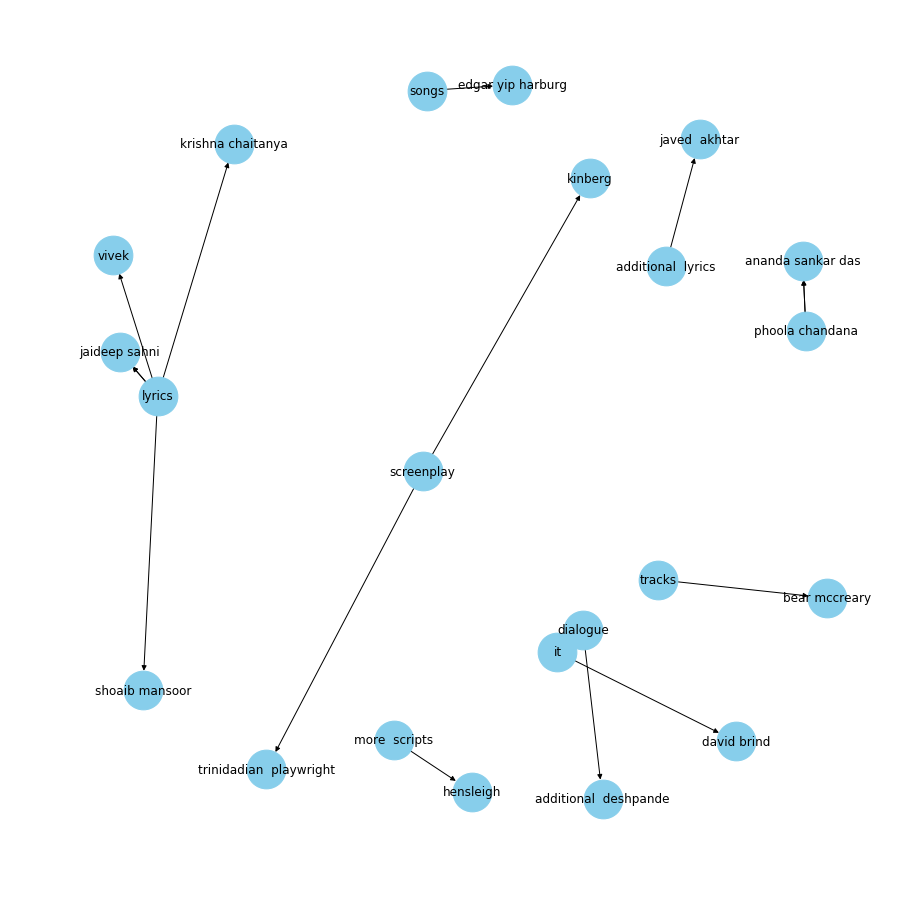

In [68]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

这个知识图谱提供了一些非凡的信息。像Javed Akhtar、Krishna Chaitanya和Jaideep Sahni这样的人都是著名的作词家，这个图形很好地捕捉了这种关系。

现在让我们看一下另一个重要谓词“released in”的知识图谱：

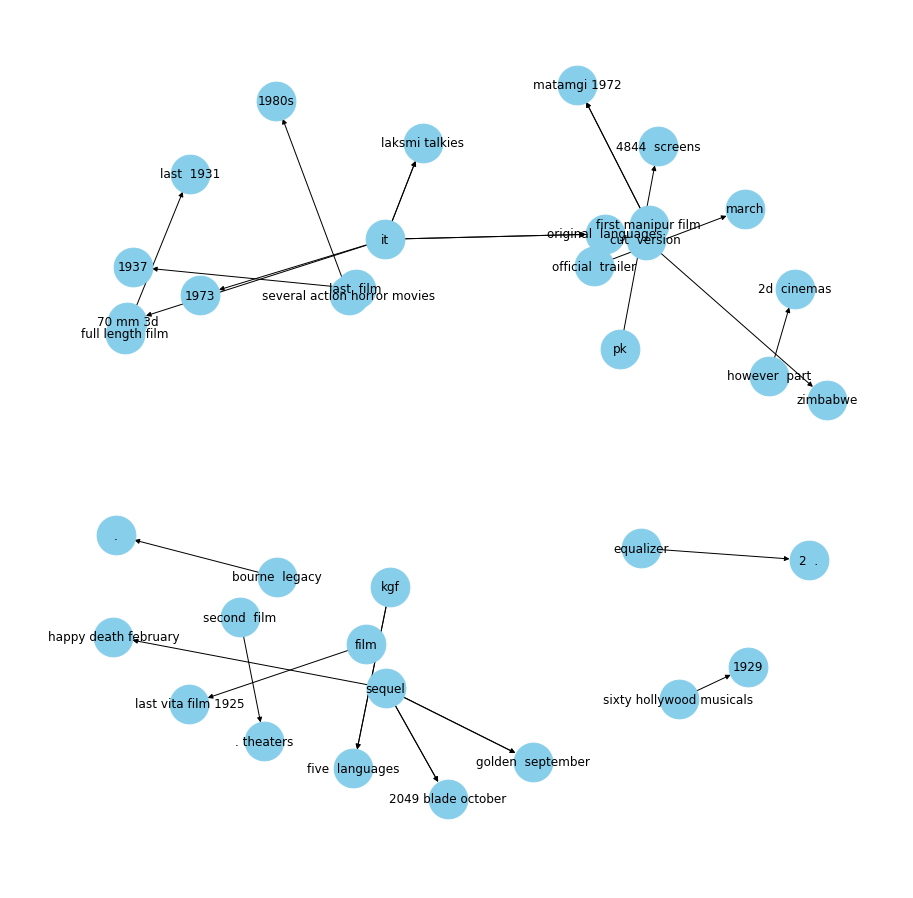

In [69]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

## 知识图谱实战

[](./knowledge_graph/extract_graph.ipynb)
